# Supplement: Reliability plots

Gaussian kernel reliability plots of BBP data and randomly generated Poisson spike trains.

<u>Required input data</u>:

- Download and uncompress `simulation.xz`, containing BBP simulation data, including the ones using the reliability simulation protocol, to a root folder.
- Run `compute_reliab_basic.py` in order to obtain `reliability_basic.npz`.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tqdm

from conntility import ConnectivityMatrix
from scipy.ndimage import gaussian_filter1d

In [19]:
def load_data_store(h5_file):
    data_dict = {}
    h5_store = h5py.File(h5_file, 'r')
    for _key in list(h5_store.keys()):
        if isinstance(h5_store[_key], h5py.Dataset):
            data_dict[_key] = np.array(h5_store[_key])
        else:  # SKIP GROUPS
            print(f'SKIPPING {_key}')
    h5_store.close()
    return data_dict

def load_data_set(h5_file, h5_sel):
    if not isinstance(h5_sel, list):
        h5_sel = [h5_sel]
    data = []
    h5_store = h5py.File(h5_file, 'r')
    for _sel in h5_sel:
        assert isinstance(h5_store[_sel], h5py.Dataset), f'ERROR: "{_sel}" is not a valid data set!'
        data.append(np.array(h5_store[_sel]))
    h5_store.close()
    return data

def load_neuron_info(working_dir):
    conn_file = os.path.join(working_dir, 'connectome.h5')
    conn_mat = ConnectivityMatrix.from_h5(conn_file)
    return conn_mat.vertices.set_index('index')

In [3]:
save_path = './figs'
if not os.path.exists(save_path):
    os.makedirs(save_path)
# save_path = None

## Real data
- From simulation campaign using "Baseline" circuit
- EXC neurons only

In [4]:
root_dir = '/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/ZENODO_simulation'
working_dir = os.path.join(root_dir, 'BlobStimReliability_O1v5-SONATA_Baseline/working_dir')
h5_file = os.path.join(working_dir, 'processed_data_store.h5')
reliab_file = os.path.join(working_dir, 'reliability_basic.npz')

### Spike train examples with different reliabilities
- Low vs. high reliabity
- At low/high firing rates

In [5]:
data_dict = load_data_store(h5_file)

reliab = np.load(reliab_file)['reliability']
reliab_sims = np.load(reliab_file)['selected_sims_index']

avg_rates = np.mean(data_dict['firing_rates'][reliab_sims, :], 0)
gids = data_dict['gids']

SKIPPING spike_signals_exc


In [6]:
print(f'Low rate, low reliab: GID IDX = {np.where(np.logical_and(np.logical_and(avg_rates > 0.05, avg_rates < 0.25), reliab < 0.05))[0][:10]}')
print(f'Low rate, high reliab: GID IDX = {np.where(np.logical_and(np.logical_and(avg_rates > 0.05, avg_rates < 0.5), reliab > 0.8))[0][:10]}')
print(f'High rate, low reliab: GID IDX = {np.where(np.logical_and(avg_rates > 2.0, reliab < 0.05))[0][:10]}')
print(f'High rate, high reliab: GID IDX = {np.where(np.logical_and(avg_rates > 3.0, reliab > 0.6))[0][:10]}')
print(f'Medium rate, low reliab: GID IDX = {np.where(np.logical_and(np.logical_and(avg_rates > 1.0, avg_rates < 1.5), reliab < 0.05))[0][:10]}')
print(f'Medium rate, high reliab: GID IDX = {np.where(np.logical_and(np.logical_and(avg_rates > 1.0, avg_rates < 1.5), reliab > 0.8))[0][:10]}')

Low rate, low reliab: GID IDX = [ 3042  4970  4997 17942 19234 22272 23794]
Low rate, high reliab: GID IDX = [6824 6885 8640 9747]
High rate, low reliab: GID IDX = [15483 18173 22853]
High rate, high reliab: GID IDX = [10210 11766 12577 13239 13673 14809]
Medium rate, low reliab: GID IDX = [15124 15128 15152 15189 15281 15306 15377 15485 15493 15530]
Medium rate, high reliab: GID IDX = [ 6223  7598  8905  9041  9867 13905]


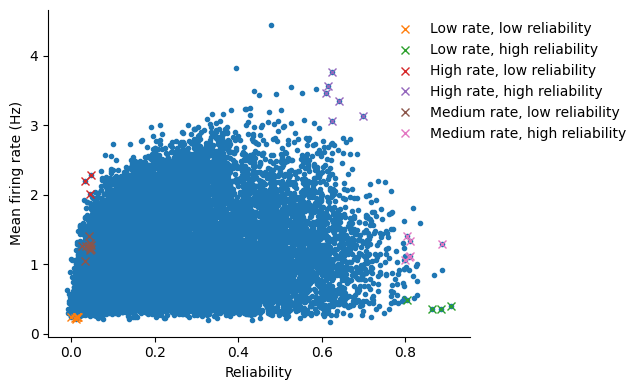

In [7]:
# Visualize selection
LL_sel = [3042, 4970, 4997, 17942, 19234, 22272, 23794]
LH_sel = [6824, 6885, 8640, 9747]
HL_sel = [15483, 18173, 22853]
HH_sel = [10210, 11766, 12577, 13239, 13673, 14809]
ML_sel = [15124, 15128, 15152, 15189, 15281, 15306, 15377, 15485, 15493, 15530]
MH_sel = [6223, 7598, 8905, 9041, 9867, 13905]


name_map = {'LL': 'Low rate, low reliability',
            'LH': 'Low rate, high reliability',
            'HL': 'High rate, low reliability',
            'HH': 'High rate, high reliability',
            'ML': 'Medium rate, low reliability',
            'MH': 'Medium rate, high reliability'}

# Plot overview
plt.figure(figsize=(7, 4))
plt.plot(reliab, avg_rates, '.')
plt.plot(reliab[LL_sel], avg_rates[LL_sel], 'x', label=name_map['LL'])
plt.plot(reliab[LH_sel], avg_rates[LH_sel], 'x', label=name_map['LH'])
plt.plot(reliab[HL_sel], avg_rates[HL_sel], 'x', label=name_map['HL'])
plt.plot(reliab[HH_sel], avg_rates[HH_sel], 'x', label=name_map['HH'])
plt.plot(reliab[ML_sel], avg_rates[ML_sel], 'x', label=name_map['ML'])
plt.plot(reliab[MH_sel], avg_rates[MH_sel], 'x', label=name_map['MH'])
plt.xlabel('Reliability')
plt.ylabel('Mean firing rate (Hz)')
plt.legend(frameon=False, loc='upper right', bbox_to_anchor=[1.4, 1.0])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# if save_path is not None:
#     plt.savefig(os.path.join(save_path, f'reliab_vs_rate_selection.png'), dpi=300)
plt.show()

In [8]:
def get_spike_times(gid, spk_frames):
    return [df[df['gid'] == gid]['t'].to_numpy() for df in spk_frames]

In [9]:
spk_frames = []
for _sim in reliab_sims:
    spk_file = os.path.join(working_dir, f'raw_spikes_exc_{_sim}.npy')
    df = pd.DataFrame(np.load(spk_file), columns=['t', 'gid'])
    df['gid'] = df['gid'].astype(int)
    spk_frames.append(df)

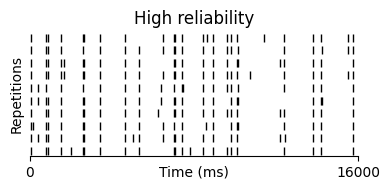

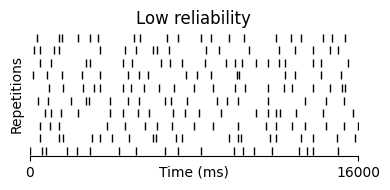

In [10]:
# Plot spike train examples
name_map_rel = {'L': 'Low reliability',
                'H': 'High reliability'}
sel_i = 0
# for sel_idx, sel_name in zip([HH_sel[sel_i], HL_sel[sel_i], LH_sel[sel_i], LL_sel[sel_i], MH_sel[sel_i], ML_sel[sel_i]], ['HH', 'HL', 'LH', 'LL', 'MH', 'ML']):
for sel_idx, sel_name in zip([MH_sel[sel_i], ML_sel[sel_i]], ['MH', 'ML']):
    spk_sel = get_spike_times(gids[sel_idx], spk_frames)

    plt.figure(figsize=(4, 2))
    for _idx, _t in enumerate(spk_sel):
        plt.plot(_t, np.full_like(_t, _idx + 1), 'k|')
    plt.xlabel('Time (ms)', labelpad=-10)
    plt.xlim([0, 16000])
    plt.xticks([0, 16000])
    plt.ylabel('Repetitions')
    plt.yticks([])
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    # plt.title(f'Reliability={reliab[sel_idx]:.2f}')
    plt.title(name_map_rel[sel_name[-1]])
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, f'spikes_{sel_name}.png'), dpi=300)
        plt.savefig(os.path.join(save_path, f'spikes_{sel_name}.svg'), dpi=300)
        plt.savefig(os.path.join(save_path, f'spikes_{sel_name}.pdf'), dpi=300)
    plt.show()

### Reliability vs. firing rates

In [20]:
nrn_info = load_neuron_info(working_dir)
cell_layer = nrn_info.loc[gids]['layer']
layers = np.unique(cell_layer)
print(f'{len(cell_layer)} cells, {len(layers)} layers: {layers}')

26567 cells, 5 layers: [2 3 4 5 6]


In [21]:
nrn_sel = [MH_sel[sel_i], ML_sel[sel_i]]
nrn_sel

[6223, 15124]

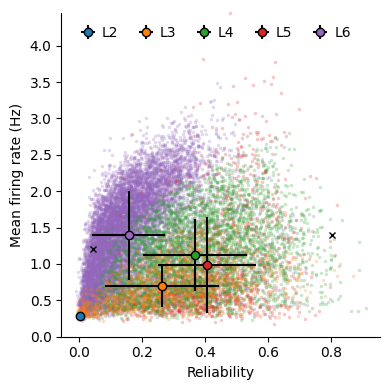

In [22]:
# Plot reliability vs. firing rates (real datas)
show_mrk = True  # Show markers of selected spike trains from above
lay_colors = plt.cm.tab10.colors[:len(layers)]
plt.figure(figsize=(4, 4))
for lidx, lay in enumerate(layers):
    plt.plot(reliab[cell_layer == lay], avg_rates[cell_layer == lay], '.', color=lay_colors[lidx], alpha=0.25, ms=5, markeredgewidth=0, zorder=-1e5 * lidx, clip_on=False)
for lidx, lay in enumerate(layers):
    plt.errorbar(np.nanmean(reliab[cell_layer == lay]), np.nanmean(avg_rates[cell_layer == lay]), xerr=np.nanstd(reliab[cell_layer == lay]), yerr=np.nanstd(avg_rates[cell_layer == lay]), fmt='o', ecolor='k', color=lay_colors[lidx], markeredgecolor='k', label=f'L{lay}', clip_on=False)
if show_mrk:
    plt.plot(reliab[nrn_sel], avg_rates[nrn_sel], 'xk', ms=5, clip_on=False)
# plt.xlim([np.nanmin(reliab), 1.0])
# plt.xlim([0, 1])
plt.ylim([0, np.nanmax(avg_rates)])
plt.xlabel('Reliability')
plt.ylabel('Mean firing rate (Hz)')
# plt.gca().spines['left'].set_zorder(-1e6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, loc='upper left', ncol=len(layers), handletextpad=0, columnspacing=1)
plt.tight_layout()
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'reliab_vs_rate{"_mrk" if show_mrk else ""}.png'), dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f'reliab_vs_rate{"_mrk" if show_mrk else ""}.svg'), dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f'reliab_vs_rate{"_mrk" if show_mrk else ""}.pdf'), dpi=600, bbox_inches='tight')
plt.show()

## Toy example with Poisson spike trains
- Random Poisson spike trains
- With and w/o mean-centering

In [32]:
# Define functions
def generate_spike_trains(res, r, T, N, sigma, seed=0, baseline_shifted=False, mean_centered=False):
    """Generates spike trains and filtered signals.
         res ... Time resolution, i.e., bin size (ms)
         r ... Avg. Poisson spike rate (Hz)
         T ... Duration (s)
         N ... Number of repetitions, i.e., trials
         sigma ... Sigma of Gaussian filter (ms); 0 or None to disable filtering
         seed ... Random generator seed (optional)
         baseline_shifted ... Baseline shift to -1 for empty spike bins (optional)
         mean_centered ... Mean removal from filtered signal (optional)
    """
    # Generate Poisson spike trains
    np.random.seed(seed)
    st = np.random.poisson(r * res * 1e-3, size=(N, int(T / (res * 1e-3)))).astype(float)

    # Shift baseline for empty spike bins
    if baseline_shifted:
        st[st == 0.0] = -1.0

    # Filter spike trains
    if sigma is not None and sigma > 0:
        st_filt = gaussian_filter1d(st, sigma / res, axis=1)
    else:
        st_filt = st

    # Center around mean
    if mean_centered:
        st_filt = st_filt - r * res * 1e-3 # Theoretical mean: r * res * 1e-3; Could be estimated by np.mean(st_filt, 1, keepdims=True)

    return st, st_filt


def plot_spike_trains(st, st_filt, T, res, xlim=None):
    """Plots spike trains and filtered signals."""
    time_axis = np.arange(0, T * 1e3, res)
    assert len(time_axis) == st.shape[1] == st_filt.shape[1], 'ERROR: Time axis mismatch!'

    N = st.shape[0]
    assert st.shape[0] == st_filt.shape[0], 'ERROR: Trial number mismatch!'

    plt.figure()
    st_scaled = st_filt.T / (np.max(st_filt) - np.min(st_filt))
    if np.min(st_scaled) < -0.5: # Shift so that not below -0.5
        st_scaled = st_scaled - np.min(st_scaled) - 0.5
    plt.plot(time_axis, st_scaled + np.arange(N), color='grey', lw=0.5)
    plt.plot(time_axis[np.where(st > 0)[1]], np.where(st > 0)[0], 'k,')
    if xlim is not None and hasattr(xlim, '__iter__') and len(xlim) == 2:
        plt.xlim((xlim[0], xlim[1]))
    plt.xlabel('Time (ms)')
    plt.ylabel('Repetitions')
    plt.title(f'Spike trains and filtered signals\n[rel = {avg_reliability(st_filt):.2f}]', fontweight='bold') # Default title    
    plt.show()


def reliability(v1, v2):
    """Computes reliability of two spike trains."""
    if np.linalg.norm(v1) * np.linalg.norm(v2) > 0.0:
        return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    else:
        return 0.0


def avg_reliability(v_filt):
    """Computes average reliability between all pairs of spike trains."""
    N_trials = v_filt.shape[0]
    avg_rel = 0.0
    for i in range(N_trials):
        for j in range(i + 1, N_trials):
            avg_rel = avg_rel + reliability(v_filt[i, :], v_filt[j, :])
    avg_rel = 2 * avg_rel / (N_trials * (N_trials - 1))
    return avg_rel


def plot_R_map(R, x_values, y_values, x_label, y_label, show_isolines=True, show_cbar=True, new_fig=True):
    """Plots reliability map."""
    assert R.shape[0] == len(y_values) and R.shape[1] == len(x_values), 'ERROR: Size mismatch!'
    x_step = np.min(np.diff(x_values))
    y_step = np.min(np.diff(y_values))
    if new_fig:
        plt.figure()
    plt.imshow(R, interpolation='nearest', vmin=0.0, vmax=1.0, extent=(min(x_values) - x_step / 2, max(x_values) + x_step / 2, max(y_values) + y_step / 2, min(y_values) - y_step / 2))
    if show_cbar:
        h_cb = plt.colorbar(label='Reliability')
        h_cb.set_ticks([0, 1])
    if show_isolines:
        plt.contour(x_values, y_values, R, cmap='Reds', alpha=0.5, vmin=0.0, vmax=1.0) # Isolines (contour)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Reliability', fontweight='bold')
    if new_fig:
        plt.show()

In [33]:
# Generate Poisson spikes (example)
res = 1.0 # Time resolution, i.e., bin size (ms)
r = 10 # Avg. rate (Hz)
T = 100 # Duration (s)
N = 10 # Number of repetitions
sigma = 100 # Sigma of Gaussian filter (ms)

st, st_filt = generate_spike_trains(res, r, T, N, sigma, seed=0, baseline_shifted=False, mean_centered=False)

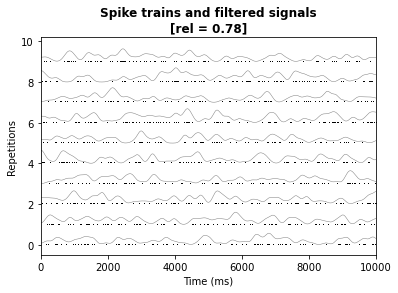

In [34]:
# Plot spikes
plot_spike_trains(st, st_filt, T, res, xlim=[0, 10000])

In [40]:
# Rerun with different combinations of rates & sigmas
res = 1 # Time resolution (ms)
r_list = np.arange(1, 21, 1) # (Hz)
sigma_list = np.arange(1, 21, 1) # (ms)

# W/o mean-centering
R1 = np.full((len(r_list), len(sigma_list)), np.nan)
for ridx in tqdm.tqdm(range(len(r_list)), desc='No mean-centering'):
    for sidx, sigma in enumerate(sigma_list):
        st, st_filt = generate_spike_trains(res, r_list[ridx], T, N, sigma, seed=0, baseline_shifted=False, mean_centered=False)
        R1[ridx, sidx] = avg_reliability(st_filt)
print()

# With mean-centering
R2 = np.full((len(r_list), len(sigma_list)), np.nan)
for ridx in tqdm.tqdm(range(len(r_list)), desc='Mean-centering'):
    for sidx, sigma in enumerate(sigma_list):
        st, st_filt = generate_spike_trains(res, r_list[ridx], T, N, sigma, seed=0, baseline_shifted=False, mean_centered=True)
        R2[ridx, sidx] = avg_reliability(st_filt)

No mean-centering: 100%|██████████| 20/20 [00:54<00:00,  2.75s/it]


Mean-centering: 100%|██████████| 20/20 [00:55<00:00,  2.79s/it]


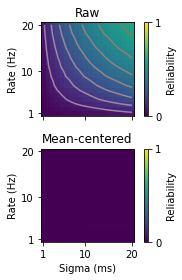

In [41]:
x_ticks = [1, 10, 20]  # Sigma (ms)
y_ticks = [1, 10, 20]  # Rate (Hz)
plt.figure(figsize=(3, 4))
plt.subplot(2, 1, 1)
plot_R_map(R1, sigma_list, r_list, 'Sigma (ms)', 'Rate (Hz)', show_isolines=True, show_cbar=True, new_fig=False)
plt.title('Raw')
# plt.title('No mean-centering', fontweight='bold')
# plt.title(None)
plt.gca().invert_yaxis()
plt.xlabel(None)
plt.gca().set_xticks(x_ticks)
plt.gca().set_xticklabels([])
plt.gca().set_yticks(y_ticks)
plt.subplot(2, 1, 2)
plot_R_map(R2, sigma_list, r_list, 'Sigma (ms)', 'Rate (Hz)', show_isolines=False, show_cbar=True, new_fig=False)
plt.title('Mean-centered')
# plt.title('Mean-centering', fontweight='bold')
# plt.title(None)
plt.gca().invert_yaxis()
plt.gca().set_xticks(x_ticks)
plt.gca().set_yticks(y_ticks)
plt.tight_layout()
if save_path is not None:
    plt.savefig(os.path.join(save_path, f'reliab_poisson.png'), dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f'reliab_poisson.svg'), dpi=600, bbox_inches='tight')
    plt.savefig(os.path.join(save_path, f'reliab_poisson.pdf'), dpi=600, bbox_inches='tight')
plt.show()